<a href="https://colab.research.google.com/github/Michael-Jimenez-C/Investigaci-n-de-operaciones/blob/main/pert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df=pd.DataFrame({"Actividad":"1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 f".split(" "),
                 "Tiempo":[40,30,30,40,40,60,40,50,30,50,5,30,30,30,10,0],
                 "dependencia":["0","0","0","0","0","0","0","0","0","0","0","2,3,4,5,6,7","8,9","10","1,11,12,13,14","15"],
                 "recurso":[5,8,8,10,10,10,8,10,10,10,2,7,7,14,5,0]})

In [ ]:
df=pd.DataFrame({"Actividad":"1 2 3 4 5 6 7 8 9".split(" "),
                 "Tiempo":[10,6,1,5,5,10,30,30,20],
                 "dependencia":"0 0 2 1,3 4 5 4 6,7 8".split(" "),
                 "recurso":[1,1,0,3,4,2,6,6,7]})

In [2]:
df=pd.DataFrame({"Actividad":"A B C D E F G H I J K L M N O S".split(" "),
                 "Tiempo":[2,4,3,6,4,2,2,5,4,2,2,4,3,1,3,0],
                 "dependencia":"0 0 0 0 B D D,C A E B,F,G G H,I I,J I,J J,K L,M,N,O".split(" "),
                 "recurso":[4,2,4,2,2,1,2,3,2,5,3,3,6,1,1,0]})

In [3]:
df

,Actividad,Tiempo,dependencia,recurso
0,A,2,0,4
1,B,4,0,2
2,C,3,0,4
3,D,6,0,2
4,E,4,B,2
5,F,2,D,1
6,G,2,"D,C",2
7,H,5,A,3
8,I,4,E,2
9,J,2,"B,F,G",5


#Prueba 1

In [4]:
class Nodo:
  def __init__(self,contenido):
    self.contenido=contenido
    self.padres=[]
    self.next=[]
  def agregar(self,nodo):
    if nodo not in self.next:
      nodo.padres.append(self)
      self.next.append(nodo)
  def __repr__(self):
    return str(self.contenido) if self.contenido!=None else ""

In [174]:
class Proyecto:
  divisiones=4
  def __init__(self,actividades,tiempos,dependencias):
    nodos=[Nodo({"actividad":"0",
         "t":0,
         "dep":None})]
    for i in range(len(actividades)):
      k={"actividad":actividades[i],
         "t":tiempos[i],
         "dep":dependencias[i].split(",")}
      nodos.append(Nodo(k))
    
    for i in nodos:
      for j in nodos:
        if i.contenido["dep"]!=None:
          if j.contenido["actividad"] in i.contenido["dep"]:
            j.agregar(i)
    self.nodos=nodos
  def rutaCritica(self) :
    for i,k in enumerate(self.nodos):
      k.contenido["tmax"]=np.inf
      k.contenido["tmin"]=0
      k.contenido["t0"]=0
      max=0

    for i in self.nodos:
      for j in i.next:
        j.contenido["tmin"]=np.maximum(j.contenido["tmin"],i.contenido["tmin"]+j.contenido["t"])
        j.contenido["t0"]=np.maximum(j.contenido["t0"],i.contenido["t0"]+i.contenido["t"])

        if len(j.next)==len([]):
          j.contenido["tmax"]=j.contenido["tmin"]
          j.contenido["TRT"]=j.contenido["tmax"]-j.contenido["tmin"]

          if max<j.contenido["tmax"]:
            max=j.contenido["tmax"]

            
    for i in reversed(self.nodos):
      for j in i.padres:
        j.contenido["tmax"]=np.minimum(j.contenido["tmax"],i.contenido["tmax"]-i.contenido["t"])
        j.contenido["TRT"]=j.contenido["tmax"]-j.contenido["tmin"]
    self.max=max

  def __gantc__(self,x):
    u=lambda x,l,s:np.piecewise(x, [x<l,(x>=l)*(x<=s),x>s],[lambda x: 0*x, lambda x: 1+0*x, lambda x: 0*x])
    f=[]
    for i in self.nodos:
      x_l=i.contenido["t0"]
      x_s=x_l+i.contenido["t"]
      f.append(u(x,x_l,x_s))
    return f
  def gant(self):
    x=np.linspace(0,self.max,self.max*Proyecto.divisiones)
    f=self.__gantc__(x)

    for i in enumerate(f):
      plt.plot(x,i[1]*i[0],label=r"Actividad "+r"$"+str(i[0])+r"$")
    plt.yticks([i for i in range(0,len(f))])
    plt.ylabel("ACTIVIDAD")
    plt.xlabel("TIEMPO")
    plt.title("DIAGRAMA DE GANT")
    plt.grid()
    plt.xlim(0)
    plt.tight_layout()
    return plt
  
  def __calcularSumaRecursos(self,x,asignacion_recurso):
    x=np.linspace(0,self.max,self.max*Proyecto.divisiones)
    rec=[0]
    rec.extend(asignacion_recurso)
    f=self.__gantc__(x)
    y=sum([f[i]*rec[i] for i in range(len(f))])

    return y

  def digrama_recurso_vs_tiempo(self,asignacion_recurso,recurso_ref):
    x=np.linspace(0,self.max,self.max*Proyecto.divisiones)
    y=self.__calcularSumaRecursos(x,asignacion_recurso)
    Yc=np.piecewise(y,[y>=recurso_ref,y<recurso_ref],[lambda y:y, lambda y:0*y+recurso_ref])

    plt.plot(x,y)
    plt.plot(x,0*x+recurso_ref)
    plt.fill_between(x,Yc,0*y+recurso_ref,color="red",alpha=.5)
    plt.xlabel("TIEMPO")
    plt.ylabel("RECURSO")   
    plt.title("RECURSO VS TIEMPO") 
    plt.grid()
    plt.xlim(0)
    plt.tight_layout()
    return plt
  def gantResumen(self,asignacion_recurso,recurso_ref):
    plt.figure(figsize=(6,8))
    plt.subplot(2,1,1)
    s.gant()
    plt.title("")
    plt.xlabel("")
    plt.xticks([i for i in range(0,self.max+1,20)],[])
    plt.subplot(2,1,2)
    s.digrama_recurso_vs_tiempo(asignacion_recurso,recurso_ref)
    plt.title("")
    plt.xticks([i for i in range(0,self.max+1,20)])
    plt.show()


  def gray_kidd(self,asignacion_recurso,recurso_ref):
    x=np.linspace(0,self.max,self.max*Proyecto.divisiones)
    y=self.__calcularSumaRecursos(x,asignacion_recurso)
    if (y<=recurso_ref).all()==True:
      return None
    #intervalos
    intervalos=[0]
    for i in self.nodos:
      x_s=i.contenido["t0"]
      x_f=x_s+i.contenido["t"]
      if x_s not in intervalos:
        intervalos.append(x_s)
      if x_f not in intervalos:
        intervalos.append(x_f)
    intervalos=np.sort(intervalos)
    #analisis:
    desp=0
    nodos=[]
    for i in range(len(intervalos)-1):
      if (y[(x>intervalos[i])*(x<intervalos[i+1])]>recurso_ref).any()==True:
        print(intervalos[i],intervalos[i+1])
        nodos=[]
        rec=[]
        for k,j in enumerate(self.nodos):
          if j.contenido["t0"]<=intervalos[i] and (j.contenido["t0"]+j.contenido["t"])>=intervalos[i+1] and j.contenido["actividad"]!="0":
            nodos.append(j)
            rec.append(asignacion_recurso[k-1])
        desp=intervalos[i+1]-intervalos[i]
        break

    for i in range(len(nodos)):
      for j in range(i,len(nodos)):
        if nodos[i].contenido["t0"]>nodos[j].contenido["t0"]:
          print(nodos[i].contenido["actividad"],nodos[j].contenido["actividad"])
          temp=nodos[i]
          nodos[i]=nodos[j]
          nodos[j]=temp

          temp2=rec[i]
          rec[i]=rec[j]
          rec[j]=temp2
        elif nodos[i].contenido["t0"]==nodos[j].contenido["t0"] and nodos[i].contenido["TRT"]>nodos[j].contenido["TRT"]:
          temp=nodos[i]
          nodos[i]=nodos[j]
          nodos[j]=temp
          
          temp2=rec[i]
          rec[i]=rec[j]
          rec[j]=temp2
        elif nodos[i].contenido["t0"]==nodos[j].contenido["t0"] and nodos[i].contenido["TRT"]==nodos[j].contenido["TRT"] and rec[i]<rec[j]:
          temp=nodos[i]
          nodos[i]=nodos[j]
          nodos[j]=temp

          temp2=rec[i]
          rec[i]=rec[j]
          rec[j]=temp2
    print([i.contenido["actividad"] for i in nodos])
    print(rec)
    suma=0
    for i in range(len(nodos)):
      if suma+rec[0]>recurso_ref or suma==recurso_ref:
        break
      suma+=rec[0]
      rec.pop(0)
      nodos.pop(0)
      
    for i in range(len(nodos)):
      nodos[i].contenido["t0"]+=desp
      nodos[i].contenido["TRT"]-=desp
      self.actualizarT0()

    #self.gant()
    #plt.show()
    #self.digrama_recurso_vs_tiempo(asignacion_recurso,recurso_ref)
    #plt.show()
    #self.gray_kidd(asignacion_recurso,recurso_ref)

  def actualizarT0(self):
    for i in self.nodos:
      for j in i.next:
        j.contenido["t0"]=np.maximum(j.contenido["t0"],i.contenido["t0"]+i.contenido["t"])
        if j.contenido["t0"]+j.contenido["t"]>self.max:
          self.max=j.contenido["t0"]+j.contenido["t"]
  
  def to_DataFrame(self):
    df=pd.DataFrame()
    for i in self.nodos[0].contenido:
      a=[]
      for j in self.nodos:
        a.append(j.contenido[i])
      df[i]=a
    return df


In [155]:
s=Proyecto(df["Actividad"],df["Tiempo"],df["dependencia"])
s.rutaCritica()

In [ ]:
s.to_DataFrame()

In [ ]:
maxday=[31,28,31,30,31,30,31,31,30,31,30,31]
mes=["ENE","FEB","MAR","ABR","MAY","JUN","JUL","AGO","SEP","OCT","NOV","DIC"]
dias=["DOM","LUN","MAR","MIE","JUE","VIE","SAB"]

In [ ]:
d=[]
a=2023
for i,j in zip(mes,maxday):
  for x in range(j):
    if dias[int(x%7)] not in ["DOM"]:
      d.append((x+1,i,a))
print(d)

In [ ]:
for i in d:
  if d[0]==(3,'ABR',2023):
    break
  d.pop(0)

for i in d:
  if len(d)<=95:
    break
  d.pop(-1)

In [ ]:
fech=[f"{i[0]}/{i[1]}/{i[2]}" for i in d]

In [ ]:
len(fech)

95

'24/JUL/2023'

In [ ]:
s.gant()
plt.title("")
plt.xticks([i for i in range(0,96,10)],[fech[i] for i in range(0,len(fech),10)],rotation=45)
plt.tight_layout(h_pad=1)
plt.savefig("GANT PSI.pdf",dpi=300)

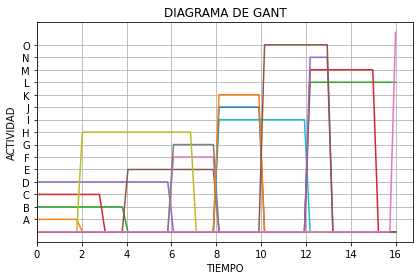

In [110]:
s.gant()
plt.yticks([i for i in range(1,16)],[chr(ord("A")+i) for i in range(0,15)])
plt.savefig("GANT.png",dpi=300)

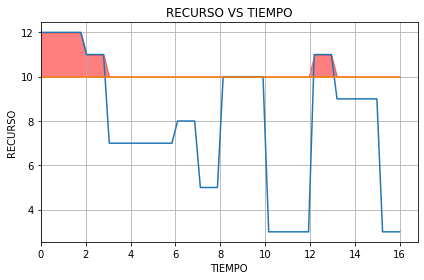

In [111]:
s.digrama_recurso_vs_tiempo(df["recurso"],10)
plt.savefig("RvsT.png",dpi=300)

In [ ]:
s.to_DataFrame()

In [179]:
s=Proyecto(df["Actividad"],df["Tiempo"],df["dependencia"])
s.rutaCritica()

4 5
C D
['D', 'C', 'E', 'H']
[2, 4, 2, 3]


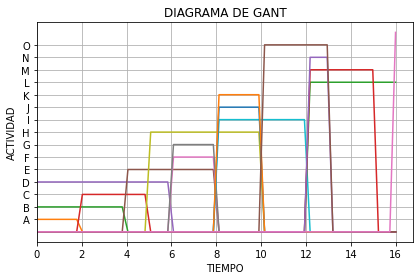

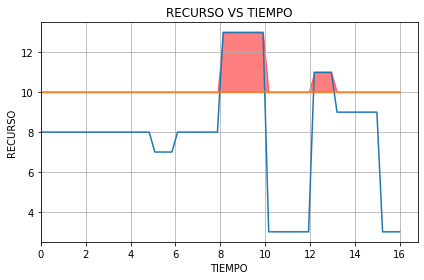

In [182]:
s.gray_kidd(df["recurso"],10)
s.gant()
plt.yticks([i for i in range(1,16)],[chr(ord("A")+i) for i in range(0,15)])
plt.show()
s.digrama_recurso_vs_tiempo(df["recurso"],10)
plt.show()

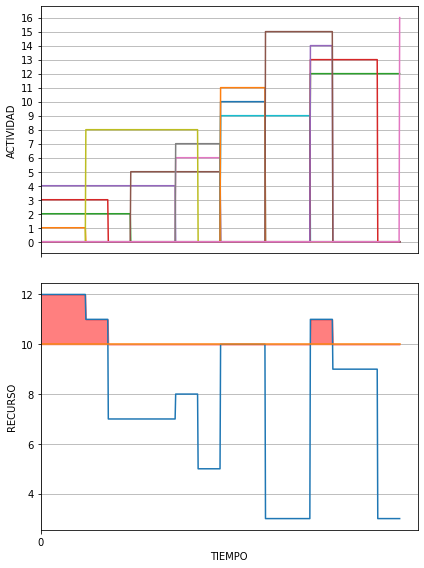

In [62]:
s.gantResumen(df["recurso"],10)

In [ ]:
k=s.to_DataFrame()
k=k.sort_values(by="t0")
k

,actividad,t,dep,tmax,tmin,t0,TRT
0,0,0,None,0.0,0,0,0.0
6,6,60,[0],60.0,60,0,0.0
8,8,50,[0],60.0,50,0,10.0
10,10,50,[0],60.0,50,0,10.0
14,14,30,[10],90.0,80,50,10.0
5,5,40,[0],60.0,40,60,20.0
4,4,40,[0],60.0,40,80,20.0
7,7,40,[0],60.0,40,80,20.0
9,9,30,[0],60.0,30,100,30.0
2,2,30,[0],60.0,30,120,30.0


#Con un objeto Actividad

In [ ]:
class Actividad:
  def __init__(self,contenido):
    self.contenido=contenido
    self.padres=[]
    self.hijos=[]
  def agregar(self,nodo):
    if nodo not in self.hijos:
      nodo.padres.append(self)
      self.hijos.append(nodo)

  def __repr__(self):
    return str(self.contenido) if self.contenido!=None else ""

  def __initRTVAR__(self):
    if "tmax" not in self.contenido:
      self.contenido["tmax"]=np.inf
      self.contenido["tmin"]=0
      self.contenido["t0"]=0
      for i in self.hijos:
        i.__initRTVAR__()

  def rutaCriticaAD(self):
    self.__initRTVAR__()
    for i in self.padres:
      self.contenido["tmin"]=np.maximum(self.contenido["tmin"],i.contenido["tmin"]+self.contenido["t"])
      self.contenido["t0"]=np.maximum(self.contenido["t0"], self.contenido["t"]+i.contenido["t0"])
    if len(self.hijos)!=len([]):
      for i in self.hijos:
        i.rutaCriticaAD()
      print(i.contenido["actividad"])
    else:
      self.contenido["tmax"]=self.contenido["tmin"]
  def rutaCriticaAT(self):
    for i in self.hijos:
      i.rutaCriticaAT()
    for i in self.padres:
      i.contenido["tmax"]=np.minimum(i.contenido["tmax"],self.contenido["tmax"]-i.contenido["t"])
  
  def rutaCritica(self):
    self.rutaCriticaAD()
    self.rutaCriticaAT()

In [ ]:
class Proyecto:
  def __init__(self,actividades,tiempos,dependencias):
    nodos=[Actividad({"actividad":"0",
         "t":0,
         "dep":None})]
    for i in range(len(actividades)):
      k={"actividad":actividades[i],
         "t":tiempos[i],
         "dep":dependencias[i].split(",")}
      nodos.append(Actividad(k))
    
    for i in nodos:
      for j in nodos:
        if i.contenido["dep"]!=None:
          if j.contenido["actividad"] in i.contenido["dep"]:
            j.agregar(i)
    self.nodos=nodos
  def to_DataFrame(self):
    df=pd.DataFrame()
    for i in self.nodos[0].contenido:
      a=[]
      for j in self.nodos:
        a.append(j.contenido[i])
      df[i]=a
    return df
  def rutaCritica(self) :
    self.nodos[0].rutaCritica()


In [ ]:
s=Proyecto(df["Actividad"],df["Tiempo"],df["dependencia"])
s.rutaCritica()

In [ ]:
s.to_DataFrame()

,actividad,t,dep,tmax,tmin,t0
0,0,0,None,10.0,0,0
1,1,40,[0],60.0,40,40
2,2,30,[0],40.0,30,30
3,3,30,[0],40.0,30,30
4,4,40,[0],30.0,40,40
5,5,40,[0],30.0,40,40
6,6,60,[0],10.0,60,60
7,7,40,[0],30.0,40,40
8,8,50,[0],20.0,50,50
9,9,30,[0],40.0,30,30
